## 期中考试

#### 1 检查环境和载入库


In [1]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

torch.__version__, torchvision.__version__

('1.10.0', '0.11.1')

#### 2 包含三层以上卷积层的CIFAR-10数据集分类

超参数设定。

In [2]:
DOWNLOAD_DATASET = True # 是否下载数据
dp = 0.5 # dropout概率
lr = 0.001 # 学习率
batch_size = 10 # 批大小
epochs = 20

数据集的下载和归一化预处理。

In [3]:
import torch
from torchvision import *

transform = transforms.Compose([     
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

train_data = datasets.CIFAR10(     
    root='./CIFAR10_train',     
    train=True,     
    transform=transform,
    download=DOWNLOAD_DATASET
)

test_data = datasets.CIFAR10(     
    root='./CIFAR10_test',     
    train=False,     
    transform=transform,
    download=DOWNLOAD_DATASET
)

Files already downloaded and verified
Files already downloaded and verified


数据集载入。

In [4]:
trainloader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

testloader = torch.utils.data.DataLoader(test_data,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=0)


数据集可视化。
输出训练集、测试集大小。

In [5]:
print("label:", train_data.classes[train_data.targets[49999]])
print("data_shape:", train_data.data[0].shape)
# print("data:", train_data.data[49999])
print("train:", train_data)
print("test:", test_data)

label: automobile
data_shape: (32, 32, 3)
train: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
test: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CIFAR10_test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
print(train_data.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


测试集十张图像数据的可视化。

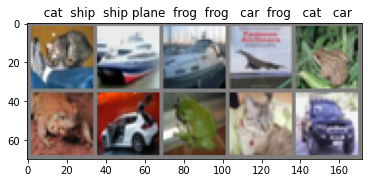

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
title = ' '.join('%5s' % classes[labels[j]] for j in range(batch_size))

imshow(utils.make_grid(images, nrow=5), title)

模型网络定义和搭建。

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, padding=1), # 3*32*32 -> 16*32*32
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2) # 16*32*32 -> 16*16*16
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, padding=1), # 16*16*16 -> 32*16*16
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2) # 32*16*16 -> 32*8*8
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1), # 32*8*8 -> 64*8*8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2) # 64*8*8 -> 64*4*4
        )
        
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1), # 64*4*4 -> 128*4*4
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2) # 128*4*4 -> 128*2*2
        )
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128*2*2, 64),
            torch.nn.ReLU(),
            # torch.nn.Dropout(dp)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            # torch.nn.Dropout(dp)
        )
        self.fc3 = torch.nn.Linear(32, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 128 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        out = F.log_softmax(x, dim=1)
        return out
 
net = Net()
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    

优化器设定。

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

损失函数设定。

In [10]:
loss = torch.nn.CrossEntropyLoss()

训练并观察收敛过程。
此处取得 iteration = 1000, batchsize = 10, total = 50000。


每一轮epoch结束对验证集进行验证，对准确率和平均损失进行计算。


In [13]:
# l_ = []
# acc_ = []

for epoch in range(epochs):
    correct = 0
    sum_loss = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        l = loss(outputs, labels)
        l.backward()
        sum_loss += l.item()
        optimizer.step()
        
        if i % 1000 == 0:
            print('Train epoch: %d [%5d/50000 (%d%%)] Loss: %.6f' % (epoch, i * batch_size, i * batch_size / 500, l))
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
        #l_.append(sum_loss * batch_size / 50000)
        #acc_.append(correct / 10000)
        
    writer.add_scalar('Loss_lr', sum_loss * batch_size / 50000, epoch)
    writer.add_scalar('Accuracy_lr', correct / 10000, epoch)
    
    print('\nTest set: Average loss: %.4f Accuracy: %d/10000 (%d%%)\n' % (sum_loss * batch_size / 50000, correct, correct / 100))
    writer.close()

Train epoch: 0 [    0/50000 (0%)] Loss: 2.253120
Train epoch: 0 [10000/50000 (20%)] Loss: 2.047525
Train epoch: 0 [20000/50000 (40%)] Loss: 1.562358
Train epoch: 0 [30000/50000 (60%)] Loss: 1.502618
Train epoch: 0 [40000/50000 (80%)] Loss: 1.898355

Test set: Average loss: 1.5335 Accuracy: 5601/10000 (56%)

Train epoch: 1 [    0/50000 (0%)] Loss: 1.135718
Train epoch: 1 [10000/50000 (20%)] Loss: 0.977138
Train epoch: 1 [20000/50000 (40%)] Loss: 1.036075
Train epoch: 1 [30000/50000 (60%)] Loss: 1.003131
Train epoch: 1 [40000/50000 (80%)] Loss: 1.348423

Test set: Average loss: 1.1270 Accuracy: 6296/10000 (62%)

Train epoch: 2 [    0/50000 (0%)] Loss: 0.920399
Train epoch: 2 [10000/50000 (20%)] Loss: 1.032900
Train epoch: 2 [20000/50000 (40%)] Loss: 0.860612
Train epoch: 2 [30000/50000 (60%)] Loss: 1.161818
Train epoch: 2 [40000/50000 (80%)] Loss: 0.929710

Test set: Average loss: 0.9512 Accuracy: 6633/10000 (66%)

Train epoch: 3 [    0/50000 (0%)] Loss: 0.842933
Train epoch: 3 [10000/50

对运行结果绘制函数曲线，实验中用tensorboard取代这种办法，此处仅为可视化方便，已取消。

使用训练模型对测试集的第170张到180张图片进行预测，结果如下（学号2019210517）

In [11]:
testloader = torch.utils.data.DataLoader(test_data,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=0)

for i, data in enumerate(testloader, 0):
    with torch.no_grad():
        inputs, labels = data
        if i <= 180 and i >= 170:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            print(i, classes[predicted])
            print(np.array(outputs))

    

170 dog
[[-2.3039403 -2.4347153 -2.289973  -2.240355  -2.366772  -2.178182
  -2.2515893 -2.336887  -2.2063527 -2.4553714]]
171 dog
[[-2.3038485 -2.4327815 -2.2885058 -2.2421937 -2.3687553 -2.1780007
  -2.2512574 -2.3357804 -2.207512  -2.455151 ]]
172 dog
[[-2.3071082 -2.4340067 -2.2854166 -2.239172  -2.3692515 -2.1769955
  -2.2509499 -2.3372622 -2.2115712 -2.451823 ]]
173 dog
[[-2.3046079 -2.4322753 -2.2876503 -2.2409766 -2.3699784 -2.1772761
  -2.2520254 -2.3368359 -2.2098536 -2.4518056]]
174 dog
[[-2.3053308 -2.4322886 -2.287162  -2.2409253 -2.3695495 -2.1762953
  -2.2520647 -2.3374655 -2.2110558 -2.451069 ]]
175 dog
[[-2.3069696 -2.433802  -2.288337  -2.2408109 -2.367515  -2.1773171
  -2.2499495 -2.3351576 -2.209372  -2.454574 ]]
176 dog
[[-2.3055148 -2.4331188 -2.285643  -2.239765  -2.369525  -2.1769667
  -2.2520046 -2.3369174 -2.211987  -2.4518788]]
177 dog
[[-2.3032084 -2.4317257 -2.28807   -2.2432065 -2.367793  -2.1786613
  -2.2512233 -2.3375494 -2.2088172 -2.4527986]]
178 dog
[

选做内容，仅使用R通道作为输入进行训练，并与之前的结果比较。

In [12]:
print(train_data.data[9999].T[0]) # R通道

[[ 62  62  67 ... 161 163 169]
 [ 61  63  78 ... 159 161 167]
 [ 60  61 115 ... 159 162 167]
 ...
 [ 64  77 100 ... 152 162 167]
 [ 82 114 119 ... 157 161 167]
 [ 62  64  63 ... 156 161 167]]


In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2) 
        )
        
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128*2*2, 64),
            torch.nn.ReLU(),
            # torch.nn.Dropout(dp)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            # torch.nn.Dropout(dp)
        )
        self.fc3 = torch.nn.Linear(32, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 128 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        out = F.log_softmax(x, dim=1)
        return out
 
net = Net()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

loss = torch.nn.CrossEntropyLoss()

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for epoch in range(epochs):
    correct = 0
    sum_loss = 0
    
    for i in range(50000):
        inputs = torch.tensor(train_data.data[i].T[0])
        inputs = torch.unsqueeze(inputs, dim=0).float()
        inputs = torch.unsqueeze(inputs, dim=0).float()

        labels = train_data.targets[i]
        labels = torch.tensor(labels)
        labels = torch.unsqueeze(torch.tensor(labels), dim=0)
        # labels = torch.nn.functional.one_hot(labels, num_classes=10)     
        optimizer.zero_grad()

        outputs = net(inputs)
        l = loss(outputs, labels)
        l.backward()
        
        sum_loss += l.item()
        optimizer.step()
        
        if i % 10000 == 0:
            print('Train epoch: %d [%5d/50000 (%d%%)] Loss: %.6f' % (epoch, i, i / 500, l))
            
    with torch.no_grad():
        for j in range(10000):
            images = torch.tensor(test_data.data[j].T[0])
            images = torch.unsqueeze(images, dim=0).float()
            images = torch.unsqueeze(images, dim=0).float()
            
            labels = test_data.targets[j]
            labels = torch.tensor(labels)
            labels = torch.unsqueeze(torch.tensor(labels), dim=0)
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
        
    writer.add_scalar('Loss_lr', sum_loss / 50000, epoch)
    writer.add_scalar('Accuracy_lr', correct / 10000, epoch)
    
    print('\nTest set: Average loss: %.4f Accuracy: %d/10000 (%d%%)\n' % (sum_loss / 50000, correct, correct / 100))
    writer.close()        

Train epoch: 0 [    0/50000 (0%)] Loss: 2.432807
Train epoch: 0 [10000/50000 (20%)] Loss: 1.236086
Train epoch: 0 [20000/50000 (40%)] Loss: 2.266639
Train epoch: 0 [30000/50000 (60%)] Loss: 3.322659
Train epoch: 0 [40000/50000 (80%)] Loss: 0.018284

Test set: Average loss: 1.6407 Accuracy: 5348/10000 (53%)

Train epoch: 1 [    0/50000 (0%)] Loss: 2.349407
Train epoch: 1 [10000/50000 (20%)] Loss: 0.273501
Train epoch: 1 [20000/50000 (40%)] Loss: 0.057889
Train epoch: 1 [30000/50000 (60%)] Loss: 2.148669
Train epoch: 1 [40000/50000 (80%)] Loss: 0.004124

Test set: Average loss: 1.3761 Accuracy: 5394/10000 (53%)

Train epoch: 2 [    0/50000 (0%)] Loss: 2.215210
Train epoch: 2 [10000/50000 (20%)] Loss: 0.138203
Train epoch: 2 [20000/50000 (40%)] Loss: 0.000607
Train epoch: 2 [30000/50000 (60%)] Loss: 3.296090
Train epoch: 2 [40000/50000 (80%)] Loss: 0.025777

Test set: Average loss: 1.2895 Accuracy: 5542/10000 (55%)

Train epoch: 3 [    0/50000 (0%)] Loss: 3.832033
Train epoch: 3 [10000/50